# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Strategy" data-toc-modified-id="Strategy-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Strategy</a></div><div class="lev2 toc-item"><a href="#Matching-Prioritization" data-toc-modified-id="Matching-Prioritization-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Matching Prioritization</a></div><div class="lev2 toc-item"><a href="#Thoughts-on-Methods" data-toc-modified-id="Thoughts-on-Methods-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Thoughts on Methods</a></div><div class="lev1 toc-item"><a href="#Sample-Data-Generation" data-toc-modified-id="Sample-Data-Generation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sample Data Generation</a></div><div class="lev1 toc-item"><a href="#Data-Loading,-Validation,-and-Prep" data-toc-modified-id="Data-Loading,-Validation,-and-Prep-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Loading, Validation, and Prep</a></div><div class="lev1 toc-item"><a href="#Linear-Program" data-toc-modified-id="Linear-Program-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Linear Program</a></div><div class="lev1 toc-item"><a href="#Post-processing" data-toc-modified-id="Post-processing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Post-processing</a></div><div class="lev1 toc-item"><a href="#Matching-Characterization" data-toc-modified-id="Matching-Characterization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Matching Characterization</a></div>

In [1]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
from scipy.optimize import linprog
from ast import literal_eval
from collections import Counter
from itertools import product
import os
import re
import matching as match # the associated script file

data_path = './'
%matplotlib inline

# Strategy
See section 4 for the particular approach taken, using a linear program. 

## Matching Prioritization
* Match tutees preferentially if they have a priority flag for a given class (have a coefficient to determine how much this matters?)
* Also prioritize "harder" classes: determine by # of students requesting tutoring in that class (again, tunable how much weight this has?)
* Match as many tutees as possible
* If >2 hours requested, try not to assign just 1
* Max # tutees per tutor: 3
    * This is a little tricky. You need a way to make each cell in the tutor/tutee/class tensor equal to one, then you can constrain that the sum for each tutor, across all students and classes, is $\le3$. If you could divide the value in each cell by itself (unless its value is 0), then you could make this work; dividing by a variable isn't possible in a linear program (LP), however.
* Try to leave no tutors with 0 tutees
    * This one isn't exactly possible in an LP, at least not any way that I can think to implement it. It has a similar issue to the above in that you'd have to convert the matrix for each tutor to be 0/1 so that you could add a term for the maximization of the sum of those matrices to the objective function.
* Max # hours/match: 3
* If tutee asks for >2 hours, don’t assign 1 hour unless necessary (can assign 2). If >4 hours, probably should assign 3 but isn’t super critical.
    * TODO
* Do not match people who were once matched and are now unmatched (they will have an entry in tutor_tutee_map with active=0)
    * I never received sample input with this information, so this wasn't really considered. To implement it, you'd just need to set a constraint that the particular row  that corresponds to that tutor/tutee pair has a sum of 0.  
* Produce multiple output files (probably by changing the relative weights for the priorities above) so they can be compared



## Thoughts on Methods

I couldn't think of a single algorithmic framework that would find an optimal solution to the problem while still being able to take in all of the priorities/constraints desired. I thought an LP would be best, but here are some other options as well.

1. Max flow algorithm
    * Create a graph where tutees/tutors only have connections if they have a common class. The flow out of each tutor node is restricted to their total hours available. For students, one could make one node for them for each class and restrict the flow through it to be the number of hours requested for that class. Then maximizing the flow maximizes the number of hours of tutoring.
    * One can do a few modifications to this to prioritize things differently. If each tutee is restricted to be just one node (not one per class) with its flow restricted to 1, then this maximizes the number of matches. After an initial round, if tutors still have time left available, one could expand that time among their existing tutees.
    * However, this framework seemed to make some of the priorities/constraints you desired difficult to implement (such as more priority being given to harder classes, more priority to certain students, etc. There are things one could try (like an initial matching round only for higher priority students or those in harder classes, followed by a general matching round), but it seemed difficult to properly express a balance between different constraints/priorities), so I ended up not implementing it.

2. Priority-sort and greedy match
    * One could just sort the list of tutees in order of 'need' where need is a function of the priority of the student for their classes, the hardness of the classes (class-level priority), and anything else one wants to factor in.
    * Then, one can merely iterate through the list of tutors and match each tutor with the first tutees possible (as these are the highest 'need' tutees). It would be easy to set how many hours one allocates based on the number the tutor has available (not more than that) and the number the tutee requested (not more than that, but perhaps less; capped at 3 hours max). It would also be easy to keep the number of tutees/tutor to 3 and to avoid multiple tutors being matched to the same tutee for the same class (which could happen in max flow).
    * I wasn't too worried about tutors ending up with 0 tutees, but one could expand this approach to also sort the list of tutors by, e.g., the number of matches they have (fewest matches first).
    * One could even sort the lists between each match that is made, to keep things updated.
    * This approach would probably be the simplest, but I didn't like it very much because it certainly doesn't get to a global optimal solution; matches would be made based on the tutee most in need right as the match is being considered, not how that match might restrict later matches. So, I didn't do much with this one either.

3. Linear program
    * Again, see section 4 for the specifics for this problem.
    * Pros
        * Finds the global maximum of whatever objective function you give it.  
        * (Linear) flexibility: anything that can be expressed as a linear function of the variables could easily be made the objective. Any linear constraints can also be added on easily
    * Cons
        * Only linear things: I wasn't able to implement, for example, the constraint that tutors have $\le3$ tutees, though this didn't seem to be an issue in my sample files. I also didn't implement anything that pushes no tutor to have 0 tutees (it's difficult to do something in terms of number of tutees; it's easy to do it in terms of number of hours of tutoring).
    * Some of the non-linear constraints could probably be implemented without too much trouble using post-processing; working on that now.

# Sample Data Generation

In [2]:
def make_sample_files(n, path=data_path):
    """
    Creates sample tutor and tutee info files so that one can test the matching script.
    The sample files will be named tutor_info.txt and tutee_info.txt and stored in the directory specified.
    Edit this function if the sample data doesn't seem realistic enough (e.g add more classes, alter the number of hours
    generally requested, etc.)
    :param n: the number of tutees to put in the tutee file; the number of tutors will be 60% of this
    :param path: path to the directory where the sample files should be saved
    """
    
    next_id = 0
    n_tutees = n
    n_tutors = int(0.6 * n)

    classes = [6.01, 6.001, 6.005, 6.006, 6.036, 6.034, 6.046, 6.047, 6.802, 6.004, 6.002, 6.878, 6.041, 6.042]
    classes = [str(class_) for class_ in classes]
    class_probs = np.array([1., 1, 2, 2, 3, 2, 4, 2, 1, 2, 1, 1, 1, 2]) # distribution over how common the classes are
    class_probs /= class_probs.sum() # normalize
    class_ids = {classes[i]: i for i in xrange(len(classes))}
    assert len(class_probs) == len(classes)
    
    ## TUTORS
    with open(path + 'tutor_info.txt', 'w') as tutor_file:
#         tutor_file.write('\t'.join(('id', 'name', 'classes', 'avail_hours', 'n_matches')) + '\n')
        for _ in xrange(n_tutors):
            # make a fake name for this person
            name = reduce(lambda x, y: x+y, np.random.choice(list('aaabcdeeefghiiijklmnooopqrsssttuuuvwxyyz'), size=np.random.randint(3, 10)))
            tid = next_id = next_id + 1 # tutor id
            avail_hours = np.random.choice([0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4])
            n_matches = np.random.choice([0, 0, 0, 0, 1, 1, 2, 3])
            class_list = np.random.choice(classes, p=class_probs, replace=False,
                                          size=np.random.choice([0, 1, 2, 3, 4, 5], p=[.01, .24, .25, .25, .15, .1]))
            class_list = [(class_ids[class_], class_) for class_ in class_list]

            tutor_file.write("\t".join((str(elem) for elem in (tid, name, class_list, avail_hours, n_matches))) + '\n')
    
    ## TUTEES
    with open(path + 'tutee_info.txt', 'w') as tutee_file:
#         tutee_file.write('\t'.join(('id', 'name', 'classes', 'n_matches')) + '\n')
        for _ in xrange(n_tutors):
            name = reduce(lambda x, y: x+y, np.random.choice(list('aaabcdeeefghiiijklmnooopqrsssttuuuvwxyyz'), size=np.random.randint(3, 10)))
            tid = next_id = next_id + 1 # tutee id
            n_matches = np.random.choice([0, 0, 0, 0, 1, 1, 2])
            class_list = np.random.choice(classes, p=class_probs, replace=False,
                                          size=np.random.choice([0, 1, 2, 3, 4, 5], p=[.01, .24, .25, .25, .15, .1]))
            class_list = [(class_ids[class_], # class id
                           class_, # class name
                           np.random.choice([1, 2, 2, 2, 3, 3, 4, 5]), # hours requested
                           np.random.choice([0, 0, 0, 0, 1])) # priority: 0 (no)/1 (yes)
                          for class_ in class_list]

            tutee_file.write("\t".join((str(elem) for elem in (tid, name, class_list, n_matches))) + '\n')

In [23]:
make_sample_files(30)
! cat $data_path/tutee_info.txt

19	iwhp	[(2, '6.005', 2, 0), (3, '6.006', 3, 0)]	1
20	qwhxrlnu	[(4, '6.036', 2, 0), (1, '6.001', 4, 0), (5, '6.034', 4, 0), (6, '6.046', 2, 1), (2, '6.005', 5, 1)]	1
21	rda	[(3, '6.006', 3, 0), (7, '6.047', 3, 0), (10, '6.002', 1, 0), (1, '6.001', 2, 0)]	1
22	isrih	[(6, '6.046', 3, 0)]	0
23	ida	[(6, '6.046', 2, 0), (9, '6.004', 2, 1), (5, '6.034', 1, 0), (10, '6.002', 2, 0), (4, '6.036', 1, 0)]	1
24	ois	[(9, '6.004', 4, 0), (10, '6.002', 3, 1), (6, '6.046', 1, 1)]	0
25	atgjg	[(6, '6.046', 4, 0), (5, '6.034', 5, 0), (10, '6.002', 3, 0), (1, '6.001', 3, 0)]	0
26	sibsu	[(3, '6.006', 4, 0), (13, '6.042', 1, 0), (2, '6.005', 2, 0), (4, '6.036', 5, 0)]	0
27	iowcz	[(2, '6.005', 2, 0), (3, '6.006', 3, 0)]	0
28	xoywiq	[(4, '6.036', 3, 1), (6, '6.046', 1, 0), (2, '6.005', 2, 0)]	0
29	yeltoosh	[(6, '6.046', 2, 0), (4, '6.036', 2, 0), (13, '6.042', 2, 1), (7, '6.047', 2, 1)]	0
30	wwbsxy	[(13, '6.042', 2, 1), (2, '6.005', 4, 0), (5, '6.034', 2, 0)]	0
31	ysttu	[(6, '6.046', 5, 0), (4, '6.036', 3, 1)

In [24]:
# does the real data look similar?
! cat /scratch/nhunt/hkn_tutor/real_data/tutor_info.txt

72	Julian Chacon-Castano	[('315', '6.003'), ('331', '6.041 (6.431)'), ('340', '6.115')]	4.0	1


# Data Loading, Validation, and Prep

In [3]:
def load_tutor_info(fname='tutor_info.txt', data_path=data_path, verbose=True):
    """
    Reads in the tutor data which must be in a file named tutor_info.txt in the directory specified by data_path
    (entered as a command-line argument with default value of the current directory).
    Columns expected in the tutor_info file are tutor id, tutor name, list of classes they will tutor, number of
    hours of availability, and number of matches they already have.
    :param verbose: whether to print out information about minor issues in the input data and how they're handled
    """
    tutor_info = pd.read_csv(data_path + fname, sep='\t', header=None, index_col=0,
                            names=['id', 'name', 'classes', 'avail_hours', 'n_matches']).sort_index()
    tutor_info.classes = tutor_info.classes.apply(literal_eval)

    n_zero_hours = (tutor_info.avail_hours == 0).sum()
    if n_zero_hours > 0:
        if verbose:
            print("{} tutors had 0 hours available and are thus being dropped.".format(n_zero_hours))
        tutor_info.drop(tutor_info[tutor_info.avail_hours == 0].index, inplace=True)

    max_matches = 3
    n_max_matches = (tutor_info.n_matches >= max_matches).sum()
    if n_max_matches > 0:
        if verbose:
            print("{} tutors had {} matches already and are thus being dropped.".format(n_max_matches, max_matches))
        tutor_info.drop(tutor_info[tutor_info.n_matches == max_matches].index, inplace=True)

    n_no_classes = (tutor_info.classes.apply(len) == 0).sum()
    if n_no_classes > 0:
        if verbose:
            print("{} tutors had an empty class list and are thus being dropped.".format(n_no_classes))
        tutor_info.drop(tutor_info[tutor_info.classes.apply(len) == 0].index, inplace=True)
    return tutor_info


def load_tutee_info(fname='tutee_info.txt', data_path=data_path, verbose=True):
    """
    Reads in the tutee data which must be in a file named tutee_info.txt in the directory specified by data_path
    (entered as a command-line argument with default value of the current directory).
    Columns expected in the tutee_info file are tutee id, tutee name, list of classes requested for tutoring and
    number of matches they already have.
    :param verbose: whether to print out information about minor issues in the input data and how they're handled
    """
    tutee_info = pd.read_csv(data_path + fname, sep='\t', header=None, index_col=0,
                            names=['id', 'name', 'classes', 'n_matches']).sort_index()
    tutee_info.classes = tutee_info.classes.apply(literal_eval)

    n_no_classes = (tutee_info.classes.apply(len) == 0).sum()
    if n_no_classes > 0:
        if verbose:
            print("{} tutees had an empty class list and are thus being dropped.".format(n_no_classes))
        tutee_info.drop(tutee_info[tutee_info.classes.apply(len) == 0].index, inplace=True)

    return tutee_info

In [4]:
tutor_info = load_tutor_info()
n_tutors = len(tutor_info)
tutor_to_idx = {tutor_info.index.values[i]: i for i in xrange(n_tutors)}
idx_to_tutor = {val: key for (key, val) in tutor_to_idx.items()}
tutor_info.head()

3 tutors had 0 hours available and are thus being dropped.
2 tutors had 3 matches already and are thus being dropped.


,name,classes,avail_hours,n_matches
id,,,,
1,yce,"[(2, 6.005)]",4,2
2,itten,"[(9, 6.004), (2, 6.005), (13, 6.042), (10, 6.0...",2,2
3,oyavdipo,"[(0, 6.01), (5, 6.034)]",4,0
4,yat,"[(2, 6.005)]",1,0
5,opjcfowux,"[(13, 6.042), (11, 6.878)]",1,0


In [5]:
tutee_info = load_tutee_info()
n_tutees = len(tutee_info)
tutee_to_idx = {tutee_info.index.values[i]: i for i in xrange(n_tutees)}
idx_to_tutee = {val: key for (key, val) in tutee_to_idx.items()}
tutee_info.head()

,name,classes,n_matches
id,,,
19,iwhp,"[(2, 6.005, 2, 0), (3, 6.006, 3, 0)]",1
20,qwhxrlnu,"[(4, 6.036, 2, 0), (1, 6.001, 4, 0), (5, 6.034...",1
21,rda,"[(3, 6.006, 3, 0), (7, 6.047, 3, 0), (10, 6.00...",1
22,isrih,"[(6, 6.046, 3, 0)]",0
23,ida,"[(6, 6.046, 2, 0), (9, 6.004, 2, 1), (5, 6.034...",1


In [6]:
class_id_name = np.concatenate((tutee_info.classes.map(lambda class_list: [class_elem[:2] for class_elem in class_list]).values,
                tutor_info.classes.values))
class_to_id = {name: idx for (idx, name) in reduce(lambda x, y: x + y, class_id_name)}

# extract just a list of names of classes per tutor/tutee; reduce these into one long list; make a Series mapping names to counts
# then set priority = n_tutees / n_tutors for each class
tutees_per_class = pd.Series(reduce(lambda x, y: x + y, tutee_info.classes.apply(lambda x: [elem[1] for elem in x]))).value_counts()
tutors_per_class = pd.Series(reduce(lambda x, y: x + y, tutor_info.classes.apply(lambda x: [elem[1] for elem in x]))).value_counts()
class_priority = (tutees_per_class / tutors_per_class).fillna(0).reset_index() # NA occurs when a class doesn't have both tutors and tutees
class_priority.rename(columns={'index': 'class_name', 0: 'priority'}, inplace=True)
class_priority.sort_values('priority', inplace=True)
class_priority.priority /= class_priority.priority.sum() # normalize

n_classes = len(class_priority)
class_to_idx = {class_priority.class_name.values[i]: i for i in xrange(n_classes)}
idx_to_class = {val: key for (key, val) in class_to_idx.items()}
get_class_idx = np.vectorize(class_to_idx.get)
class_priority.head()

,class_name,priority
8,6.041,0.000000
13,6.878,0.000000
2,6.004,0.039604
5,6.01,0.039604
12,6.802,0.039604


# Linear Program

This part is tricky. What we really have is a 3D tensor of shape (n_tutors, n_tutees, n_classes). The value at each cell $(i,j,k)$ of the tensor is the number of hours that tutor $T_i$ is tutoring tutee (student, hereafter) $S_j$ in class $C_k$. However, we want to represent each element of this tensor as a variable so that we can optimize the tutoring with a linear program. So, we ravel the tensor into one dimension. We just have to be careful to keep the proper order of things. We'll mentally ravel the 3D tensor into 1D in reading order: top left to bottom right, front to back. This means that students change the most quickly, then tutors, then classes. As an example:
$$(T_0,S_0,C_0), (T_0,S_1,C_0),...,(T_1,S_0,C_0),(T_1,S_1,C_0),...,(T_0,S_0,C_1),(T_0,S_1,C_1),...$$
We'll refer to the 1D array as $A$ (creative). If there are $n_t$ teachers, $n_s$ students, and $n_c$ classes, then we index it like:
$$(T_i,S_j,C_k)=A_{j+n_s*i+(n_s*n_t)*c}$$
To make this simpler to write, we may denote it $A_{i,j,k}$ at times, but the above is what is meant by that.

**Objective function**

We'll optimize a weighted sum of the number of hours of tutoring; it will be weighted by per class priorities (more priority to classes where more hours were requested) and the individual priorities given in the input file for particular student and class combinations. To scale how important the priorities are versus just maximizing the number of hours of tutoring, we'll use two parameters $\lambda_c$ for priorities for entire classes and $\lambda_s$ for priorities for particular students (in particular classes). The function to be maximized is then:
$$\sum_{i,j,k} A_{i,j,k} * (\lambda_c * PC_i) * (\lambda_s * PS_{j,k})$$
where $PC_i$ is the priority for the $i$'th class and $PS_{i,j}$ is the priority of class $j$ for student $i$ (to make things simpler, we can scale all of the priorities by their respective $\lambda$'s ahead of time and drop those terms in the objective function)

**Constraints**
* $A_{i,j,k}=0$ if $T_i$ or $S_j$ doesn't have $C_k$ in their classes lists.
    * We can do this by multiplying by 0 the cells that are valid and the others by 1; then we constrain the sum to be 0. As no cell can have a negative value (a constraint we also give), this will force all invalid class cells to 0.
* The maximum number of hours per match is 3, so each cell is $\le3$. Each cell must also be $\ge0$, so we can just enter bounds of (0,3) (inclusive) for each variable.
* No student receives more hours of tutoring for a class than requested; no tutor tutors more hours than they were available.


**Desired Constraints**

See the list of priorities in section 1 for other things that would be nice to include but that don't fit well into a linear program (perhaps a quadratic program would make some of them possible?).

In [7]:
def get_idx(tutor_idx, tutee_idx, class_idx):
    """
    Computes the index in the 1D array corresponding to (tutor_idx, tutee_idx, class_idx) in the
    imagined 3D tensor
    """
    assert tutor_idx < n_tutors
    assert tutee_idx < n_tutees
    assert class_idx < n_classes
    return tutee_idx + n_tutees * tutor_idx + n_tutees * n_tutors * class_idx

def get_triple_idx(idx):
    """
    Does the inverse of get_idx: returns the (tutor_idx, tutee_idx, class_idx) corresponding to idx
    """
    class_idx = 0
    while idx - (n_tutees * n_tutors) >= 0:
        class_idx += 1
        idx -= (n_tutees * n_tutors)
    
    tutor_idx = 0
    while idx - n_tutees >= 0:
        tutor_idx += 1
        idx -= n_tutees
    tutee_idx = idx
    return tutor_idx, tutee_idx, class_idx

In [30]:
n_variables = n_tutors * n_tutees * n_classes
max_hours = 3
var_bounds = (0, max_hours) # same bounds for all variables

In [31]:
class_list_bound = 0
class_list_constraint = np.ones((1, n_variables)) # set indices to 0 where the proposed matchings are valid

for tutor_idx in xrange(n_tutors):
    tutor_class_indices = get_class_idx([elem[1] for elem in tutor_info.classes.iloc[tutor_idx]]) # elem[1] is class name
    for class_idx in tutor_class_indices:
        for tutee_idx in xrange(n_tutees):
            tutee_class_indices = get_class_idx([elem[1] for elem in tutee_info.classes.iloc[tutee_idx]])
            if class_idx in tutee_class_indices:
                class_list_constraint[0, get_idx(tutor_idx, tutee_idx, class_idx)] = 0

In [32]:
# hours requested/available bounds
# similar to above but tutees need one constraint per class (# hours requested is per class)

hours_constraints = []
hours_bounds = []

for tutor_idx in xrange(n_tutors):
    class_indices = get_class_idx([elem[1] for elem in tutor_info.classes.iloc[tutor_idx]]) # elem[1] is class name
    hours_bounds.append(tutor_info.avail_hours.iloc[tutor_idx])
    constraint = np.zeros((1, n_variables)) # set indices to 1 where the proposed class is valid for this tutor
    for class_idx in class_indices:
        for tutee_idx in xrange(n_tutees):
            constraint[0, get_idx(tutor_idx, tutee_idx, class_idx)] = 1
    hours_constraints.append(constraint)

for tutee_idx in xrange(n_tutees):
    class_indices = get_class_idx([elem[1] for elem in tutee_info.classes.iloc[tutee_idx]]) # elem[1] is class name
    hours_requested = [elem[2] for elem in tutee_info.classes.iloc[tutee_idx]]
    for i in xrange(len(class_indices)):
        class_idx = class_indices[i]
        hours_bounds.append(hours_requested[i])
        constraint = np.zeros((1, n_variables)) # set indices to 1 where the proposed class is valid for this tutee
        for tutor_idx in xrange(n_tutors):
            constraint[0, get_idx(tutor_idx, tutee_idx, class_idx)] = 1
        hours_constraints.append(constraint)

hours_constraints = np.concatenate(hours_constraints, axis=0)
hours_bounds = np.array(hours_bounds)

In [8]:
def get_objective(lambda_classes, lambda_students):
    # scale priorities by lambdas
    scaled_class_priorities = lambda_classes * class_priority.priority.values
    objective_function = np.ones(n_variables)

    for class_idx in xrange(n_classes):
        priority = scaled_class_priorities[class_idx]
        if priority > 1:
            print(priority)
        for tutor_idx in xrange(n_tutors):
            for tutee_idx in xrange(n_tutees):
                objective_function[get_idx(tutor_idx, tutee_idx, class_idx)] *= priority

    for tutee_idx in xrange(n_tutees):
        class_indices = get_class_idx([elem[1] for elem in tutee_info.classes.iloc[tutee_idx]]) # elem[1] is class name
        priorities = [elem[3] for elem in tutee_info.classes.iloc[tutee_idx]]
        for i in xrange(len(class_indices)):
            class_idx = class_indices[i]
            priority = lambda_students * (1 + priorities[i]) # so priority of 0 -> 1
            for tutor_idx in xrange(n_tutors):
                before = objective_function[get_idx(tutor_idx, tutee_idx, class_idx)]
                objective_function[get_idx(tutor_idx, tutee_idx, class_idx)] *= priority
                after = objective_function[get_idx(tutor_idx, tutee_idx, class_idx)]
    return objective_function


def solve(objective_function):
    solution = linprog(-objective_function, options={'disp': True},
                       A_ub=hours_constraints, b_ub=hours_bounds,
                       A_eq=class_list_constraint, b_eq=class_list_bound)
    if solution.x.max() > max_hours:
        print('Quick solution exceeded max_hours ({} hours in a matching; max is {}).'.format(solution.x.max(), max_hours))
        print('Running slower, bounded program.')
        solution = linprog(-objective_function, bounds=(0, max_hours), options={'disp': True},
                           A_ub=hours_constraints, b_ub=hours_bounds,
                           A_eq=class_list_constraint, b_eq=class_list_bound)
    return solution

In [34]:
%%time
objective_function = get_objective(2, 2)
solution = solve(objective_function)

Optimization terminated successfully.
         Current function value: -23.532468  
         Iterations: 24
Quick solution exceeded max_hours (4.0 hours in a matching; max is 3).
Running slower, bounded program.
Optimization terminated successfully.
         Current function value: -23.532468  
         Iterations: 26
CPU times: user 23.6 s, sys: 26 s, total: 49.6 s
Wall time: 49.6 s


In [9]:
def get_matching(solution, i=0, save=False):
    """
    :param solution: returned from scipy.optimize.linprog
    :param i: number of this matching; used to name the saved file
    """
    matched_indices = np.argwhere(solution.x != 0).ravel()
    matches = []
    for matched_idx in matched_indices:
        tutor_idx, tutee_idx, class_idx = get_triple_idx(matched_idx)
        tutor_id = idx_to_tutor[tutor_idx]
        tutor_name = tutor_info.name.loc[tutor_id]
        tutee_id = idx_to_tutee[tutee_idx]
        tutee_name = tutee_info.name.loc[tutee_id]
        class_name = idx_to_class[class_idx]
        class_id = class_to_id[class_name]
        n_hours = solution.x[matched_idx]
        matches.append([tutor_id, tutor_name, tutee_id, tutee_name, class_id, class_name, n_hours])
    matches = pd.DataFrame(matches,
                           columns=['tutor_id', 'tutor_name', 'tutee_id', 'tutee_name', 'class_id', 'class_name', 'n_hours'])
    if save:
        print("Saving matching to {}matches_{}.tsv".format(data_path, i))
        matches.to_csv(data_path + 'matches_{}.tsv'.format(i), sep='\t', index=False)
    return matches

In [28]:
matches = get_matching(solution)
matches.head()

,tutor_id,tutor_name,tutee_id,tutee_name,class_id,class_name,n_hours
0,8,avogttus,19,othduyt,2,6.005,1.0
1,9,ran,23,iyy,3,6.006,1.0
2,9,ran,27,askukqc,3,6.006,1.0
3,4,imrw,20,ysc,5,6.034,1.0
4,5,eesou,20,ysc,4,6.036,1.0


In [125]:
lambda_classes = [2, 5]
lambda_students = [.0001, 100]
use_product = True
if use_product:
    lambdas = list(product(lambda_classes, lambda_students))
else:
    lambdas = zip(lambda_classes, lambda_students)

for i in xrange(len(lambdas)):
    objective_function = get_objective(*lambdas[i])
    solution = solve(objective_function)
    get_matching(solution, i=i, save=True)

Optimization terminated successfully.
         Current function value: -0.001108   
         Iterations: 26
Saving matching to ./matches_0.tsv
Optimization terminated successfully.
         Current function value: -1107.692308
         Iterations: 24
Saving matching to ./matches_1.tsv
Optimization terminated successfully.
         Current function value: -0.002769   
         Iterations: 26
Saving matching to ./matches_2.tsv
Optimization terminated successfully.
         Current function value: -2769.230769
         Iterations: 24
Saving matching to ./matches_3.tsv


# Post-processing

 If we stick with a linear program, either my script or the one that compares the matchings could be extended to do some post-hoc processing to add in these other constraints. For example, if one tutor has no tutees at all, one could unmatch any tutor who has $\ge2$ tutees if one of those tutees shares a class with the unmatched tutor. One can also remove any matchings beyond the third for a single tutor (and then perhaps match that tutee with any tutor that still has time available for that class)
This may be helpful. I did just confirm that in my example file, only 16/18 tutors were matched, though 5 had two matchings.

Consider doing this instead:
1. do matches that are 0/1; can constrain each cell to be in the range (0, 1) and each tutor's matrix to sum to 1 (so they're only matched to one student for one class)
    * could also consider not constraining the tutors to only have one match; then this would be doing as many matches as possible. However, I think people would end up with too few hours then.
2. Process:
    * based on the number of hours a student requested, assign them a certain amount of tutoring for that class (e.g. if they requested >4 hours, assign 3; if >2, assign 2; if 2/1, assign 1). Maybe tend to give more hours if a student is priority
    * subtract the relevant number of hours from the tutors available ours in tutor_info (the version in memory, not on disk)
    * remove that class from the tutee's request list (so they won't be matched with multiple tutors for it)
    * If a tutor now has 3 tutors, remove them from tutor_info so that they don't get any more matches (if they have any remaining hours available, assign those to the tutees they already have, if those tutees requested more tutoring time)
3. Iterate steps 1 & 2 until step 1 produces no matches, then stop.

In [10]:
data_path = './'
iterative_matching = True
max_tutees_per_tutor = 3

if iterative_matching:
    max_hours = 1
else:
    max_hours = 3

verbose = True
use_product = False
lambda_classes = [2]
lambda_students = [2]

if use_product:
    lambdas = list(product(lambda_classes, lambda_students))
else:
    lambdas = zip(lambda_classes, lambda_students)

# we'll need the complete data for post-processing
tutor_info_complete = match.load_tutor_info(data_path)
tutee_info_complete = match.load_tutee_info(data_path)

# these copies will be modified during the matching process
tutor_info = tutor_info_complete.copy()
tutee_info = tutee_info_complete.copy()

matchings = []
iter_number = 0
while True:
    iter_number += 1
    print("\nOn iteration", iter_number)
    
    n_tutors = len(tutor_info)
    tutor_to_idx = {tutor_info.index.values[i]: i for i in xrange(n_tutors)}
    idx_to_tutor = {val: key for (key, val) in tutor_to_idx.items()}

    n_tutees = len(tutee_info)
    tutee_to_idx = {tutee_info.index.values[i]: i for i in xrange(n_tutees)}
    idx_to_tutee = {val: key for (key, val) in tutee_to_idx.items()}

    ### class priorities and info
    class_priority, class_to_id, class_to_idx, idx_to_class = match.get_class_priority_and_mappings(tutor_info, tutee_info)
    n_classes = len(class_priority)
    get_class_idx = np.vectorize(class_to_idx.get)

    ### bounds/constraints on the linear program

    n_variables = n_tutors * n_tutees * n_classes

    var_bounds = (0, max_hours) # same bound for all matchings
    class_list_bounds, class_list_constraints = match.get_class_list_constraints(tutor_info, tutee_info, n_variables, get_class_idx)
    hours_bounds, hours_constraints = match.get_hours_constraints(tutor_info, tutee_info, n_variables, get_class_idx, iterative_matching)

    objective_function = match.get_objective(lambdas[0][0], lambdas[0][1], class_priority, n_tutors, n_tutees, n_classes, get_class_idx,
                                            tutee_info)

    solution = match.solve(objective_function, hours_constraints, hours_bounds, class_list_constraints, class_list_bounds, var_bounds)

    matching = match.get_matching(solution, 0, tutor_info, tutee_info, idx_to_class, class_to_id, return_matching=True)
    
    if len(matching) == 0:
        break
    
    matchings.append(matching)

    match.update_info(tutor_info, tutee_info, matching)
    
    if len(tutor_info) == 0 or len(tutee_info) == 0:
        break

matchings = pd.concat(matchings).reset_index(drop=True)
matchings

3 tutors had 0 hours available and are thus being dropped.
2 tutors had 3 matches already and are thus being dropped.

On iteration 1
Optimization terminated successfully.
         Current function value: -3.047129   
         Iterations: 27

On iteration 2
Optimization terminated successfully.
         Current function value: -0.788774   
         Iterations: 7

On iteration 3
Optimization terminated successfully.
         Current function value: -0.827179   
         Iterations: 4


,tutor_id,tutor_name,tutee_id,tutee_name,class_id,class_name,n_hours
0,14,dpyds,23,ida,9,6.004,1
1,3,oyavdipo,36,dsg,0,6.01,1
2,2,itten,30,wwbsxy,13,6.042,1
3,5,opjcfowux,29,yeltoosh,13,6.042,1
4,1,yce,19,iwhp,2,6.005,1
5,4,yat,20,qwhxrlnu,2,6.005,1
6,6,odaags,22,isrih,6,6.046,2
7,8,fuegeytl,24,ois,6,6.046,1
8,10,itel,20,qwhxrlnu,6,6.046,1
9,7,taedmi,19,iwhp,3,6.006,2


In [11]:
tutor_info

,name,classes,avail_hours,n_matches
id,,,,


**Ensure no tutors have 0 matches (as far as possible)**

Unless the priorities have changed the problem too much, any tutor that we remove from a matching will be unable to be matched with another tutee (otherwise, they would already have been matched with that tutee and one of the zero match tutors matched with their current tutee during the iterative LP) thus it should be fairly equivalent which tutor we take a match away from (in the sense that we can't pick an optimal tutor as one who, if removed, will still be able to tutor somebody else instead). Thus we'll just pick the first valid tutor we find who has the most matches to swap with a zero match tutor (as long as the tutor we're swapping out has at least one match).

If one wanted to be a little more sophisticated, one could also consider swapping in a zero-match tutor for a previously matched tutor preferentially if the zero-match tutor could provide more hours of tutoring than the previously matched one (if the tutee is not already being tutored for as many hours as they had requested) or if the tutor you swapped out would be able to use their hours of tutoring on their other matched tutees (which we at least approximate with this strategy because a tutor with more tutees is more likely to be able to use their other hours elsewhere).

In [12]:
# pretend that some tutors were left with no matches, just to test
tutor_info = pd.DataFrame([[9999, 'oaisjdf', [(2, '6.005')], 2, 0]], columns=['id', 'name', 'classes', 'avail_hours', 'n_matches']).set_index('id')
zero_match_tutors = tutor_info[tutor_info.n_matches == 0]

In [13]:
for tutor_id in zero_match_tutors.index:
    class_ids = map(lambda class_elem: class_elem[0], zero_match_tutors.loc[tutor_id, 'classes']) # just get the ids
    matching_to_swap = None
    most_matches = 0
    for row in matchings.index:
        if matchings.loc[row, 'class_id'] in class_ids:
            swapped_tutor_id = matchings.loc[row, 'tutor_id']
            n_matches = matchings.tutor_id.value_counts().loc[swapped_tutor_id]
            if n_matches > max(1, most_matches):
                most_matches = n_matches
                matching_to_swap = [row, swapped_tutor_id, matchings.loc[row, 'n_hours'], matchings.loc[row, 'tutee_id'], matchings.loc[row, 'class_id']]
                
    if matching_to_swap: # not None
        # update the matching to use the zero-match tutor swapped for the old one
        row, swapped_tutor_id, swapped_hours, tutee_id, class_id = matching_to_swap
        hours_requested = filter(lambda class_elem: class_elem[0] == class_id, tutee_info_complete.loc[tutee_id, 'classes'])[0][2]
        hours_matched = min(zero_match_tutors.loc[tutor_id, 'avail_hours'], hours_requested)
        matchings.loc[row, 'tutor_id'] = tutor_id
        matchings.loc[row, 'tutor_name'] = zero_match_tutors.loc[tutor_id, 'name']
        matchings.loc[row, 'n_hours'] = hours_matched
        
        # also update the tutor info based on the swap; we'll try one more LP, just in case
        tutor_info.loc[tutor_id, 'n_matches'] += 1
        tutor_info.loc[tutor_id, 'avail_hours'] -= hours_matched
        
        if swapped_tutor_id in tutor_info.index: # edit existing entry
            tutor_info.loc[swapped_tutor_id, 'n_matches'] -= 1
            tutor_info.loc[swapped_tutor_id, 'avail_hours'] += swapped_hours
        else: # put an entry back in; make sure to update hours and matchings based on existing matchings
            tutor_info = tutor_info.append(tutor_info_complete.loc[swapped_tutor_id])
            tutor_info.loc[swapped_tutor_id, 'n_matches'] = len(matchings.loc[[swapped_tutor_id]])
            tutor_info.loc[swapped_tutor_id, 'avail_hours'] -= matchings.loc[[swapped_tutor_id], 'n_hours'].sum()
        
        if tutor_info.loc[tutor_id, 'avail_hours'] == 0:
            tutor_info.drop(tutor_id, inplace=True)

In [14]:
tutor_info

,name,classes,avail_hours,n_matches
id,,,,
10,itel,"[(6, 6.046), (5, 6.034), (2, 6.005)]",2,1


In [16]:
# call main again, just in case, and append any new matchings
tutor_info.to_csv('tmp/tutor_info.txt', sep='\t', header=None)
tutee_info.to_csv('tmp/tutee_info.txt', sep='\t', header=None)

matching = match.main('tmp/', max_hours, verbose, use_product, lambda_classes, lambda_students, iterative_matching=True, return_matching=True)
update_info(tutor_info, tutee_info, matching)
matchings = pd.concat((matchings, matching))


Solving LP with lambda_classes = 2, lambda_students = 2.
Optimization terminated successfully.
         Current function value: -0.008571   
         Iterations: 3


In [21]:
hours_remaining = tutor_info_complete.avail_hours - matchings.groupby('tutor_id').n_hours.sum().sort_index()
hours_remaining = hours_remaining[hours_remaining > 0]
hours_remaining

1     3.0
2     1.0
10    1.0
dtype: float64

In [22]:
for tutor_id in hours_remaining.index:
    matchings.set_index('tutor_id', inplace=True)
    tutor_info_tmp = tutor_info_complete.loc[[tutor_id]].copy() # selecting with "[]" keeps it a dataframe instead of a series
    tutor_info_tmp.loc[:, 'avail_hours'] = hours_remaining.loc[tutor_id]
    tutee_info_tmp = tutee_info_complete.loc[matchings.loc[[tutor_id]].tutee_id].copy()
    
    for i in xrange(len(tutee_info_tmp)):
        tutee_id = tutee_info_tmp.index[i]
        matched_class = filter(lambda class_elem: class_elem[0] == matchings.loc[[tutor_id]].iloc[i].class_id, tutee_info_tmp.iloc[i].classes)
        tutee_info_tmp.set_value(tutee_id, 'classes', matched_class)

    try:
        os.mkdir('tmp')
    except OSError:
        pass

    tutor_info_tmp.to_csv('tmp/tutor_info.txt', sep='\t', header=None)
    tutee_info_tmp.to_csv('tmp/tutee_info.txt', sep='\t', header=None)

    matching = match.main('tmp/', max_hours, verbose, use_product, lambda_classes, lambda_students, iterative_matching=False, return_matching=True)
    matchings = matchings.reset_index().set_index(['tutor_id', 'tutee_id'])
    for row_idx in xrange(len(matching)):
        tutee_id, n_hours = matching.iloc[row_idx].loc[['tutee_id', 'n_hours']]
        matchings.loc[(tutor_id, tutee_id), 'n_hours'] += n_hours
    matchings.reset_index(inplace=True)


Solving LP with lambda_classes = 2, lambda_students = 2.
Optimization terminated successfully.
         Current function value: -0.040000   
         Iterations: 1
Quick solution exceeded max_hours (2.0 hours in a matching; max is 1).
Running slower, bounded program.
Optimization terminated successfully.
         Current function value: -0.020000   
         Iterations: 1

Solving LP with lambda_classes = 2, lambda_students = 2.
Optimization terminated successfully.
         Current function value: -4.020000   
         Iterations: 2

Solving LP with lambda_classes = 2, lambda_students = 2.
Optimization terminated successfully.
         Current function value: -4.020000   
         Iterations: 2


In [23]:
assert all(matchings.groupby('class_id').tutee_id.value_counts() == 1)
assert all(matchings.tutor_id.value_counts() <= 3)

# Matching Characterization

In [25]:
tutee_info = load_tutee_info()
n_tutees = len(tutee_info)
tutor_info = load_tutor_info()
n_tutors = len(tutor_info)

3 tutors had 0 hours available and are thus being dropped.
2 tutors had 3 matches already and are thus being dropped.


In [58]:
def print_matching_info(data_path='./', verbose=False):
    stats = []
    
    # ~copied from code in LP section; defines hours_requested_per_class
    class_id_name = np.concatenate((tutee_info.classes.map(lambda class_list: [class_elem[:2] for class_elem in class_list]).values,
                    tutor_info.classes.values))
    class_to_id = {name: idx for (idx, name) in reduce(lambda x, y: x + y, class_id_name)}

    # the lists in classes have elements (class_id, class_name, hours_requested, priority)
    # find the total number of hours requested per class by making a dict: {name: hours} for each row, then convert
    # to a Counter so that you can sum them all together into one

    hours_per_class_list = tutee_info.classes.apply(lambda x: {elem[1]: elem[2] for elem in x}).values
    hours_requested_per_class = sum((Counter(d) for d in hours_per_class_list), Counter())

    for class_ in class_to_id:
        if class_ not in hours_requested_per_class:
            hours_requested_per_class[class_] = 0 # no tutees requested this class, though there are tutors available

    hours_requested_per_class = pd.DataFrame(hours_requested_per_class.items(), columns=['class_name', 'hours']).sort_values('class_name')
    
    priority_students_per_class = tutee_info.classes.apply(lambda x: {elem[1]: elem[3] for elem in x}).values
    priority_students_per_class = sum((Counter(d) for d in priority_students_per_class), Counter())
    priority_students_per_class = pd.DataFrame(priority_students_per_class.items(), columns=['class_name', 'n_priority_students'])
    
    n_priority_students = priority_students_per_class.n_priority_students.sum()
    
    for matching_name in filter(lambda fname: re.match('matches_lc_.+_ls_.+_.+\.tsv', fname), os.listdir(data_path)):
        matching = pd.read_csv(data_path + matching_name, sep='\t')
        
        n_tutors_matched = len(matching.tutor_id.unique())
        percent_tutors_matched = n_tutors_matched / n_tutors * 100 

        n_tutees_matched = len(matching.tutee_id.unique())
        percent_tutees_matched = n_tutees_matched / n_tutees * 100

        total_tutor_hours = tutor_info.avail_hours.sum()
        total_tutee_hours = hours_requested_per_class.hours.sum()
        hours_matched = matching.n_hours.sum()
        
        n_priority_matches = 0
        for i in matching.index:
            tutee_id, matched_class_id = matching.loc[i, ['tutee_id', 'class_id']]
            tutee_classes = tutee_info.loc[tutee_id, 'classes']
            priority_classes = filter(lambda class_: class_[3] == 1, tutee_classes)
            if matched_class_id in [class_[0] for class_ in tutee_classes]:
                n_priority_matches += 1
        
        if verbose:
            print("For matching: {}".format(matching_name))
            print("Tutors matched: {}/{} ({:.2f}%); Tutees matched: {}/{} ({:.2f} %)"
                  .format(n_tutors_matched, n_tutors, percent_tutors_matched,
                          n_tutees_matched, n_tutees, percent_tutees_matched))
            print("Priority students matched: {}/{} ({}%)"
                  .format(n_priority_matches, n_priority_students, n_priority_matches / n_priority_students * 100))


            print("Total hours tutors available: {}".format(total_tutor_hours))
            print("Total hours tutees requested: {}".format(total_tutee_hours))
            print("Hours matched: {}".format(hours_matched))
            print("")
        stats.append([matching_name, n_tutors_matched, n_tutors, percent_tutors_matched, n_tutees_matched, n_tutees,
                      percent_tutees_matched, total_tutor_hours, hours_matched, total_tutee_hours, n_priority_students,
                      n_priority_matches])
    stats = pd.DataFrame(stats, columns=['matching_name', 'n_tutors_matched', 'n_tutors', 'percent_tutors_matched',
                                         'n_tutees_matched', 'n_tutees', 'percent_tutees_matched', 'total_tutor_hours',
                                         'hours_matched', 'total_tutee_hours', 'n_priority_students', 'n_priority_matches'])
    stats.set_index('matching_name', inplace=True)
    return stats

For matching: matches_lc_2.0_ls_1.0_iter.tsv
Tutors matched: 13/13 (100.00%); Tutees matched: 13/18 (72.22 %)
Priority students matched: 20/13 (153.846153846%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 29

For matching: matches_lc_2.0_ls_1000.0_iter.tsv
Tutors matched: 13/13 (100.00%); Tutees matched: 14/18 (77.78 %)
Priority students matched: 21/13 (161.538461538%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 29

For matching: matches_lc_2.0_ls_10.0_iter.tsv
Tutors matched: 13/13 (100.00%); Tutees matched: 13/18 (72.22 %)
Priority students matched: 20/13 (153.846153846%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 29

For matching: matches_lc_2.0_ls_0.1_iter.tsv
Tutors matched: 13/13 (100.00%); Tutees matched: 14/18 (77.78 %)
Priority students matched: 21/13 (161.538461538%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 31

For matching

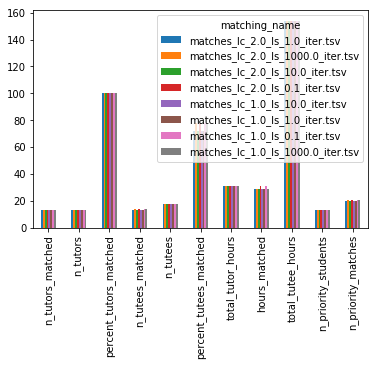

In [59]:
stats = print_matching_info(verbose=True)
stats.transpose().plot.bar()

For matching number: 0
Tutors matched: 13/13 (100.00%); Tutees matched: 11/18 (61.11 %)
Priority students matched: 22/13 (169.230769231%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 31

For matching number: 1
Tutors matched: 13/13 (100.00%); Tutees matched: 10/18 (55.56 %)
Priority students matched: 19/13 (146.153846154%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 31

For matching number: 2
Tutors matched: 13/13 (100.00%); Tutees matched: 10/18 (55.56 %)
Priority students matched: 20/13 (153.846153846%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 31

For matching number: 3
Tutors matched: 13/13 (100.00%); Tutees matched: 10/18 (55.56 %)
Priority students matched: 19/13 (146.153846154%)
Total hours tutors available: 31
Total hours tutees requested: 154
Hours matched: 31

For matching number: 4
Tutors matched: 13/13 (100.00%); Tutees matched: 10/18 (55.56 %)
Priority student

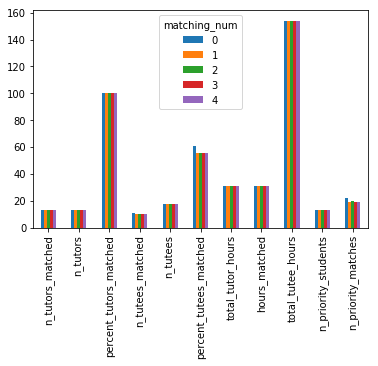

In [86]:
stats = print_matching_info(range(5), verbose=True)
stats.transpose().plot.bar()

In [33]:
matching.head()

,tutor_id,tutor_name,tutee_id,tutee_name,class_id,class_name,n_hours
0,8,avogttus,19,othduyt,2,6.005,1.0
1,9,ran,23,iyy,3,6.006,1.0
2,9,ran,27,askukqc,3,6.006,1.0
3,4,imrw,20,ysc,5,6.034,1.0
4,5,eesou,20,ysc,4,6.036,1.0
